In [1]:
%load_ext autoreload
%autoreload 2

from copy import deepcopy

import torch
import torch.nn as nn
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import math
import os, sys
from tqdm import tqdm
import random

from denoising_diffusion_pytorch import GaussianDiffusion
from denoising_diffusion_pytorch.denoising_diffusion_pytorch import SinusoidalPosEmb, unnormalize_to_zero_to_one
from denoising_diffusion_pytorch.progressive_distillation import ProgressiveDistillationGaussianDiffusion


C:\Users\lukov\miniconda3\envs\dd\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['figure.figsize'] = [12, 5]

In [3]:

class OneDModel(torch.nn.Module):
    def __init__(self, dim=16, **kw):
        super().__init__(**kw)
        self.channels = self.out_dim = 1
        self.self_condition = False
        time_dim = dim * 4

        sinu_pos_emb = SinusoidalPosEmb(dim)

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, dim)
        )

        self.main = torch.nn.ModuleList([
            torch.nn.Linear(1, dim),
            torch.nn.GELU(),
            torch.nn.Linear(dim, dim),
            torch.nn.GELU(),
            torch.nn.Linear(dim, dim),
            torch.nn.GELU(),
            torch.nn.Linear(dim, dim),
            torch.nn.GELU(),
            torch.nn.Linear(dim, 1)
        ])

    def forward(self, x_t, t, self_cond=None):
        """ x: (batsize, 1, 1, 1)"""
        x_t = x_t.squeeze(-1).squeeze(-1)

        temb = self.time_mlp(t)

        h = self.main[0](x_t)
        h = h + temb
        for layer in self.main[1:]:
            h = layer(h)

        h = h[:, :, None, None]
        return h


class OneDDataset(torch.utils.data.Dataset):
    def __init__(self, **kw):
        super().__init__(**kw)
        self.peaks = [0, 0.2, 0.8, 1]
        self.var = 0.001

    def __getitem__(self, i):
        # randomly choose one of the peaks
        ret = random.choice(self.peaks)
        ret = ret + random.gauss(0, self.var)
        return torch.tensor([ret])[:, None, None]

    def __len__(self):
        return 4000

    def __iter__(self):
        for i in range(len(self)):
            yield self[i]





In [4]:

m = OneDModel(64)
x = torch.randn((5, 1, 1, 1))
t = torch.rand((5,))
# print(x, t)

# y = m(x, t)
# print(y)
timesteps = 512

diffusion = ProgressiveDistillationGaussianDiffusion(model=m, image_size=1, timesteps=timesteps,  #)
                                                     jumpsched=[1, 8, 64, 256, 512])
                                                     # jumpsched = [1, 2,4,8,16,32, 64, 128, 256, 512])
                                                     # jumpsched = 2)

ds = OneDDataset()
dl = torch.utils.data.DataLoader(ds, batch_size=256)

print(len(ds))
#samples = [x[0, 0, 0].item() for x in ds]
#print(samples[0:100])
# _ = plt.hist(samples, density=True, bins=100)
# plt.show()

4000


In [ ]:
device = torch.device("cuda:0")
diffusion.to(device)
done = False

In [ ]:
initepochs = 2000
# train the base DDPM
optimizer = torch.optim.Adam(diffusion.model.parameters(), lr=1e-3, betas=(0.9, 0.99))
print("Training base DDPM")
with tqdm(initial=0, total=initepochs * len(dl)) as pbar:
    for epoch in range(initepochs):
        losses = []
        for batch in dl:
            batch = batch.to(device)

            loss = diffusion(batch)
            loss.backward()
            losses.append(loss.cpu().item())

            pbar.set_description(f'loss: {np.mean(losses):.4f}')

            optimizer.step()
            optimizer.zero_grad()

            diffusion.on_after_optim_step()

            pbar.update(1)

# models.append(diffusion)
print("done training")


In [ ]:
basemodel = deepcopy(diffusion)

In [ ]:
sampled_images = basemodel.sample(batch_size=2000)
print(sampled_images.shape)  # (4, 3, 128, 128)
sampled_images = sampled_images[:, 0, 0, 0]
# print(sampled_images)
_ = plt.hist(sampled_images.cpu().numpy(), density=True, bins=200)
plt.show()

In [ ]:
diffusion = deepcopy(basemodel)
diffusion.jumpsched = [1, 8, 64, 256, 512]
diffusion.distillphase[0] = 0

In [ ]:
distillepochs = 320
# distill for first case (improved progressive distillation)
optimizer = torch.optim.Adam(diffusion.model.parameters(), lr=1e-3, betas=(0.9, 0.99))
models = []
with tqdm(initial=0, total=(len(diffusion.jumpsched)-1) * distillepochs * len(dl)) as pbar:
    for jumpsize in diffusion.jumpsched[1:]:
        print(f"Current jump size: {jumpsize}")
        diffusion.increase_jump_size()
        print(f"increased jump size from {diffusion.get_prev_jump_size()} to {diffusion.get_jump_size()}")
        
        for epoch in range(distillepochs):
            losses = []
            for batch in dl:
                batch = batch.to(device)

                loss = diffusion(batch)
                loss.backward()
                losses.append(loss.cpu().item())

                optimizer.step()
                optimizer.zero_grad()

                diffusion.on_after_optim_step()

                pbar.update(1)
                pbar.set_description(f'loss: {np.mean(losses):.6f}')
                
        print(f'loss: {np.mean(losses):.6f}')
        models.append(deepcopy(diffusion))

# models.append(diffusion)
print("done training")


In [ ]:

for model in models:
    sampled_images = model.sample(batch_size=2000)
    print(sampled_images.shape)  # (4, 3, 128, 128)
    sampled_images = sampled_images[:, 0, 0, 0]
    # print(sampled_images)
    _ = plt.hist(sampled_images.cpu().numpy(), density=True, bins=200)
    plt.show()

In [ ]:
models1 = models[:]

In [ ]:
diffusion = deepcopy(basemodel)
diffusion.jumpsched = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
diffusion.distillphase[0] = 0

In [ ]:
distillepochs = 200
# distill for first case (improved progressive distillation)
optimizer = torch.optim.Adam(diffusion.model.parameters(), lr=1e-3, betas=(0.9, 0.99))
models = []
with tqdm(initial=0, total=(len(diffusion.jumpsched)-1) * distillepochs * len(dl)) as pbar:
    for jumpsize in diffusion.jumpsched[1:]:
        print(f"Current jump size: {jumpsize}")
        diffusion.increase_jump_size()
        print(f"increased jump size from {diffusion.get_prev_jump_size()} to {diffusion.get_jump_size()}")
        
        for epoch in range(distillepochs):
            losses = []
            for batch in dl:
                batch = batch.to(device)

                loss = diffusion(batch)
                loss.backward()
                losses.append(loss.cpu().item())

                optimizer.step()
                optimizer.zero_grad()

                diffusion.on_after_optim_step()

                pbar.update(1)
                pbar.set_description(f'loss: {np.mean(losses):.6f}')
                
        print(f'loss: {np.mean(losses):.6f}')
        models.append(deepcopy(diffusion))

# models.append(diffusion)
print("done training")


In [ ]:

for model in models:
    sampled_images = model.sample(batch_size=2000)
    print(sampled_images.shape)  # (4, 3, 128, 128)
    sampled_images = sampled_images[:, 0, 0, 0]
    # print(sampled_images)
    _ = plt.hist(sampled_images.cpu().numpy(), density=True, bins=200)
    plt.show()

In [ ]:
def show_trajectories(model, refmodel, numtraj=10, range=(-1.2, 1.2)):
    x_T = np.linspace(range[0], range[1], numtraj)
    
    sampled_images, times, imgacc, x0acc = refmodel.sample(numtraj, 
                                                        x_T=torch.tensor(x_T)[:, None, None, None].to(torch.float)
                                                                     .to(diffusion.betas.device),
                                                           return_trajectories=True)
    
    
    print(len(times), len(imgacc))
    
    trajs = [[x_t_i] for x_t_i in x_T]
    
    for img in imgacc:
        img = img[:,0,0,0].cpu().numpy()
        for img_i, traj in zip(img, trajs):
            traj.append(img_i)
        
    fig = plt.figure(figsize = (15,10))
    ax = fig.add_subplot(111)
    for traj in trajs:
        ax.plot(times, traj, "blue")
    ax.set_title('trajectories')
    
    sampled_images, times, imgacc, x0acc = model.sample(numtraj, 
                                                        x_T=torch.tensor(x_T)[:, None, None, None].to(torch.float)
                                                                     .to(diffusion.betas.device),
                                                       return_trajectories=True)
    
    print(len(times), len(imgacc))
    
    trajs = [[x_t_i] for x_t_i in x_T]
    
    for img in imgacc:
        img = img[:,0,0,0].cpu().numpy()
        for img_i, traj in zip(img, trajs):
            traj.append(img_i)
        
    for traj in trajs:
        ax.plot(times, traj, "ro-")
    ax.set_title('trajectories')

    plt.show()

    return trajs

In [ ]:
_ = show_trajectories(models1[-3], basemodel, numtraj=21)

In [ ]:
_ = show_trajectories(models[-4], basemodel, numtraj=21)

In [ ]:
def compute_traj_dist(model, model2, refmodel, batsize=2000):
    x_T = torch.randn((batsize, 1, 1, 1)).to(device)
    samples = model.sample(batsize, x_T=x_T)
    samples2 = model2.sample(batsize, x_T=x_T)
    refsamples = refmodel.sample(batsize, x_T=x_T)
    ret = torch.norm(samples - refsamples)**2
    ret2 = torch.norm(samples2 - refsamples)**2
    return ret, ret2
    # print(((samples - refsamples) ** 2).sum())
    # print(samples[:5], refsamples[:5])

In [ ]:
retas, retbs = [], []
for _ in range(20):
    reta, retb = compute_traj_dist(models1[-1], models[-1], basemodel)
    retas.append(reta)
    retbs.append(retb)
    
retas = torch.stack(retas)
retbs = torch.stack(retbs)
    
print(f"{torch.mean(retas).item():.4f}+-{torch.std(retas):.4f}, {torch.mean(retbs).item():.4f}+-{torch.std(retbs):.4f}")

sampling loop time step: 100%|█████████████████████████████████████████████████████| 512/512 [00:00<00:00, 1230.49it/s]


torch.Size([2000, 1, 1, 1])


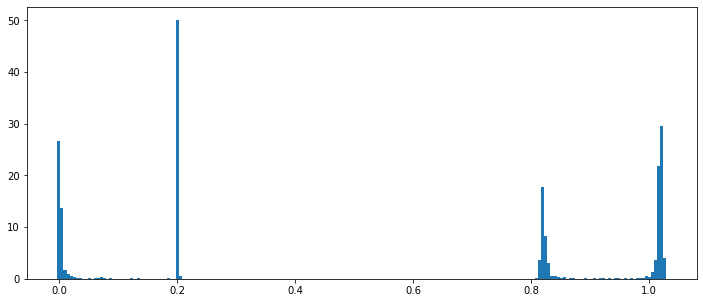

In [9]:
sampled_images = basemodel.sample(batch_size=2000)
print(sampled_images.shape)  # (4, 3, 128, 128)
sampled_images = sampled_images[:, 0, 0, 0]
# print(sampled_images)
_ = plt.hist(sampled_images.cpu().numpy(), density=True, bins=200)
plt.show()

In [10]:
diffusion = deepcopy(basemodel)
diffusion.jumpsched = [1, 8, 64, 256, 512]
diffusion.distillphase[0] = 0

In [11]:
distillepochs = 320
# distill for first case (improved progressive distillation)
optimizer = torch.optim.Adam(diffusion.model.parameters(), lr=1e-3, betas=(0.9, 0.99))
models = []
with tqdm(initial=0, total=(len(diffusion.jumpsched)-1) * distillepochs * len(dl)) as pbar:
    for jumpsize in diffusion.jumpsched[1:]:
        print(f"Current jump size: {jumpsize}")
        diffusion.increase_jump_size()
        print(f"increased jump size from {diffusion.get_prev_jump_size()} to {diffusion.get_jump_size()}")
        
        for epoch in range(distillepochs):
            losses = []
            for batch in dl:
                batch = batch.to(device)

                loss = diffusion(batch)
                loss.backward()
                losses.append(loss.cpu().item())

                optimizer.step()
                optimizer.zero_grad()

                diffusion.on_after_optim_step()

                pbar.update(1)
                pbar.set_description(f'loss: {np.mean(losses):.6f}')
                
        print(f'loss: {np.mean(losses):.6f}')
        models.append(deepcopy(diffusion))

# models.append(diffusion)
print("done training")


loss: 0.005067:   0%|                                                                | 5/20480 [00:00<13:03, 26.13it/s]

Current jump size: 8
increased jump size from 1 to 8


loss: 0.011679:  25%|███████████████▎                                             | 5131/20480 [01:19<04:01, 63.51it/s]

loss: 0.000022
Current jump size: 64
increased jump size from 8 to 64


loss: 0.029005:  50%|██████████████████████████████                              | 10256/20480 [02:37<02:20, 72.81it/s]

loss: 0.000447
Current jump size: 256
increased jump size from 64 to 256


loss: 0.037162:  75%|█████████████████████████████████████████████               | 15379/20480 [03:38<00:56, 90.25it/s]

loss: 0.000214
Current jump size: 512
increased jump size from 256 to 512


loss: 0.000002: 100%|████████████████████████████████████████████████████████████| 20480/20480 [04:31<00:00, 75.39it/s]

loss: 0.000002
done training


sampling loop time step: 100%|███████████████████████████████████████████████████████| 64/64 [00:00<00:00, 1560.63it/s]


torch.Size([2000, 1, 1, 1])


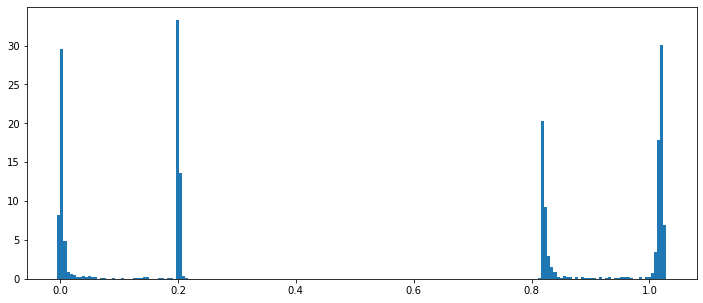

sampling loop time step: 100%|█████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1599.66it/s]


torch.Size([2000, 1, 1, 1])


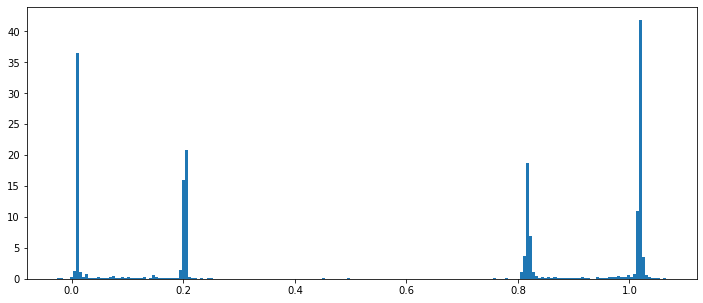

sampling loop time step: 100%|██████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 999.12it/s]


torch.Size([2000, 1, 1, 1])


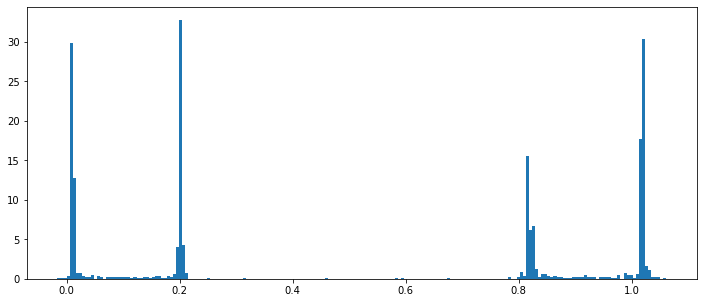

sampling loop time step: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.51it/s]


torch.Size([2000, 1, 1, 1])


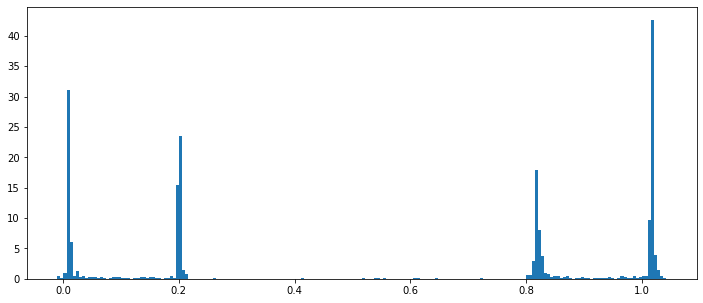

In [12]:

for model in models:
    sampled_images = model.sample(batch_size=2000)
    print(sampled_images.shape)  # (4, 3, 128, 128)
    sampled_images = sampled_images[:, 0, 0, 0]
    # print(sampled_images)
    _ = plt.hist(sampled_images.cpu().numpy(), density=True, bins=200)
    plt.show()

In [13]:
models1 = models[:]

In [14]:
diffusion = deepcopy(basemodel)
diffusion.jumpsched = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
diffusion.distillphase[0] = 0

In [15]:
distillepochs = 200
# distill for first case (improved progressive distillation)
optimizer = torch.optim.Adam(diffusion.model.parameters(), lr=1e-3, betas=(0.9, 0.99))
models = []
with tqdm(initial=0, total=(len(diffusion.jumpsched)-1) * distillepochs * len(dl)) as pbar:
    for jumpsize in diffusion.jumpsched[1:]:
        print(f"Current jump size: {jumpsize}")
        diffusion.increase_jump_size()
        print(f"increased jump size from {diffusion.get_prev_jump_size()} to {diffusion.get_jump_size()}")
        
        for epoch in range(distillepochs):
            losses = []
            for batch in dl:
                batch = batch.to(device)

                loss = diffusion(batch)
                loss.backward()
                losses.append(loss.cpu().item())

                optimizer.step()
                optimizer.zero_grad()

                diffusion.on_after_optim_step()

                pbar.update(1)
                pbar.set_description(f'loss: {np.mean(losses):.6f}')
                
        print(f'loss: {np.mean(losses):.6f}')
        models.append(deepcopy(diffusion))

# models.append(diffusion)
print("done training")


loss: 0.005640:   0%|                                                                | 9/28800 [00:00<10:27, 45.86it/s]

Current jump size: 2
increased jump size from 1 to 2


loss: 0.000509:  11%|██████▊                                                      | 3218/28800 [00:32<04:37, 92.06it/s]

loss: 0.000877
Current jump size: 4
increased jump size from 2 to 4


loss: 0.000367:  22%|█████████████▎                                              | 6418/28800 [01:03<03:42, 100.70it/s]

loss: 0.000426
Current jump size: 8
increased jump size from 4 to 8


loss: 0.000515:  33%|████████████████████▎                                        | 9618/28800 [01:34<03:14, 98.51it/s]

loss: 0.000010
Current jump size: 16
increased jump size from 8 to 16


loss: 0.000799:  45%|██████████████████████████▎                                | 12818/28800 [02:05<02:37, 101.36it/s]

loss: 0.000029
Current jump size: 32
increased jump size from 16 to 32


loss: 0.001205:  56%|████████████████████████████████▊                          | 16018/28800 [02:37<02:05, 102.06it/s]

loss: 0.000058
Current jump size: 64
increased jump size from 32 to 64


loss: 0.004001:  67%|███████████████████████████████████████▎                   | 19218/28800 [03:07<01:34, 101.92it/s]

loss: 0.000084
Current jump size: 128
increased jump size from 64 to 128


loss: 0.002958:  78%|█████████████████████████████████████████████▉             | 22418/28800 [03:38<01:02, 102.43it/s]

loss: 0.000639
Current jump size: 256
increased jump size from 128 to 256


loss: 0.047976:  89%|█████████████████████████████████████████████████████▎      | 25618/28800 [04:09<00:33, 94.58it/s]

loss: 0.000031
Current jump size: 512
increased jump size from 256 to 512


loss: 0.000068: 100%|███████████████████████████████████████████████████████████| 28800/28800 [04:40<00:00, 102.70it/s]

loss: 0.000068
done training


In [ ]:

for model in models:
    sampled_images = model.sample(batch_size=2000)
    print(sampled_images.shape)  # (4, 3, 128, 128)
    sampled_images = sampled_images[:, 0, 0, 0]
    # print(sampled_images)
    _ = plt.hist(sampled_images.cpu().numpy(), density=True, bins=200)
    plt.show()

In [ ]:
def show_trajectories(model, refmodel, numtraj=10, range=(-1.2, 1.2)):
    x_T = np.linspace(range[0], range[1], numtraj)
    
    sampled_images, times, imgacc, x0acc = refmodel.sample(numtraj, 
                                                        x_T=torch.tensor(x_T)[:, None, None, None].to(torch.float)
                                                                     .to(diffusion.betas.device),
                                                           return_trajectories=True)
    
    
    print(len(times), len(imgacc))
    
    trajs = [[x_t_i] for x_t_i in x_T]
    
    for img in imgacc:
        img = img[:,0,0,0].cpu().numpy()
        for img_i, traj in zip(img, trajs):
            traj.append(img_i)
        
    fig = plt.figure(figsize = (15,10))
    ax = fig.add_subplot(111)
    for traj in trajs:
        ax.plot(times, traj, "blue")
    ax.set_title('trajectories')
    
    sampled_images, times, imgacc, x0acc = model.sample(numtraj, 
                                                        x_T=torch.tensor(x_T)[:, None, None, None].to(torch.float)
                                                                     .to(diffusion.betas.device),
                                                       return_trajectories=True)
    
    print(len(times), len(imgacc))
    
    trajs = [[x_t_i] for x_t_i in x_T]
    
    for img in imgacc:
        img = img[:,0,0,0].cpu().numpy()
        for img_i, traj in zip(img, trajs):
            traj.append(img_i)
        
    for traj in trajs:
        ax.plot(times, traj, "ro-")
    ax.set_title('trajectories')

    plt.show()

    return trajs

In [ ]:
_ = show_trajectories(models1[-3], basemodel, numtraj=21)

In [ ]:
_ = show_trajectories(models[-4], basemodel, numtraj=21)

In [ ]:
def compute_traj_dist(model, model2, refmodel, batsize=2000):
    x_T = torch.randn((batsize, 1, 1, 1)).to(device)
    samples = model.sample(batsize, x_T=x_T)
    samples2 = model2.sample(batsize, x_T=x_T)
    refsamples = refmodel.sample(batsize, x_T=x_T)
    ret = torch.norm(samples - refsamples)**2
    ret2 = torch.norm(samples2 - refsamples)**2
    return ret, ret2
    # print(((samples - refsamples) ** 2).sum())
    # print(samples[:5], refsamples[:5])

In [ ]:
retas, retbs = [], []
for _ in range(20):
    reta, retb = compute_traj_dist(models1[-1], models[-1], basemodel)
    retas.append(reta)
    retbs.append(retb)
    
retas = torch.stack(retas)
retbs = torch.stack(retbs)
    
print(f"{torch.mean(retas).item():.4f}+-{torch.std(retas):.4f}, {torch.mean(retbs).item():.4f}+-{torch.std(retbs):.4f}")

sampling loop time step: 100%|██████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 1484.29it/s]


torch.Size([2000, 1, 1, 1])


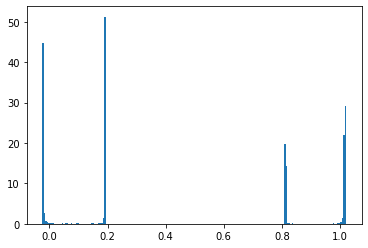

In [9]:
sampled_images = basemodel.sample(batch_size=2000)
print(sampled_images.shape)  # (4, 3, 128, 128)
sampled_images = sampled_images[:, 0, 0, 0]
# print(sampled_images)
_ = plt.hist(sampled_images.cpu().numpy(), density=True, bins=200)
plt.show()

In [10]:
diffusion = deepcopy(basemodel)
diffusion.jumpsched = [1, 8, 64, 256, 512]
diffusion.distillphase[0] = 0

In [11]:
distillepochs = 320
# distill for first case (improved progressive distillation)
optimizer = torch.optim.Adam(diffusion.model.parameters(), lr=1e-3, betas=(0.9, 0.99))
models = []
with tqdm(initial=0, total=(len(diffusion.jumpsched)-1) * distillepochs * len(dl)) as pbar:
    for jumpsize in diffusion.jumpsched[1:]:
        print(f"Current jump size: {jumpsize}")
        diffusion.increase_jump_size()
        print(f"increased jump size from {diffusion.get_prev_jump_size()} to {diffusion.get_jump_size()}")
        
        for epoch in range(distillepochs):
            losses = []
            for batch in dl:
                batch = batch.to(device)

                loss = diffusion(batch)
                loss.backward()
                losses.append(loss.cpu().item())

                optimizer.step()
                optimizer.zero_grad()

                diffusion.on_after_optim_step()

                pbar.update(1)
                pbar.set_description(f'loss: {np.mean(losses):.6f}')
                
        print(f'loss: {np.mean(losses):.6f}')
        models.append(deepcopy(diffusion))

# models.append(diffusion)
print("done training")


loss: 0.003477:   0%|                                                                        | 15/20480 [00:00<04:20, 78.42it/s]

Current jump size: 8
increased jump size from 1 to 8


loss: 0.010189:  25%|█████████████████▌                                                    | 5131/20480 [01:16<04:25, 57.76it/s]

loss: 0.000035
Current jump size: 64
increased jump size from 8 to 64


loss: 0.032370:  50%|██████████████████████████████████▌                                  | 10254/20480 [02:39<02:32, 66.96it/s]

loss: 0.000223
Current jump size: 256
increased jump size from 64 to 256


loss: 0.049838:  75%|███████████████████████████████████████████████████▊                 | 15379/20480 [03:44<00:58, 87.57it/s]

loss: 0.000130
Current jump size: 512
increased jump size from 256 to 512


loss: 0.000010: 100%|█████████████████████████████████████████████████████████████████████| 20480/20480 [04:41<00:00, 72.82it/s]

loss: 0.000010
done training


sampling loop time step: 100%|████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 1335.07it/s]


torch.Size([2000, 1, 1, 1])


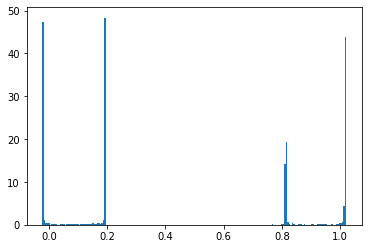

sampling loop time step: 100%|██████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1317.46it/s]


torch.Size([2000, 1, 1, 1])


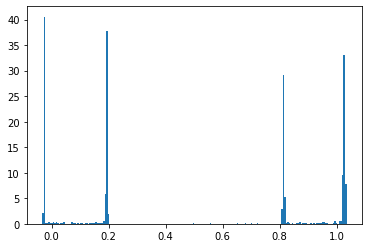

sampling loop time step: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 956.08it/s]


torch.Size([2000, 1, 1, 1])


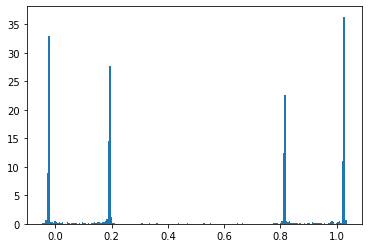

sampling loop time step: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 723.16it/s]


torch.Size([2000, 1, 1, 1])


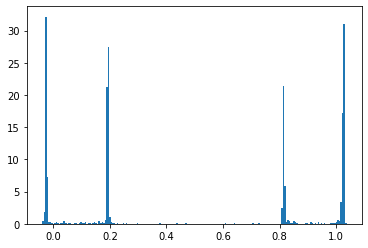

In [12]:

for model in models:
    sampled_images = model.sample(batch_size=2000)
    print(sampled_images.shape)  # (4, 3, 128, 128)
    sampled_images = sampled_images[:, 0, 0, 0]
    # print(sampled_images)
    _ = plt.hist(sampled_images.cpu().numpy(), density=True, bins=200)
    plt.show()

In [13]:
models1 = models[:]

In [14]:
diffusion = deepcopy(basemodel)
diffusion.jumpsched = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
diffusion.distillphase[0] = 0

In [15]:
distillepochs = 200
# distill for first case (improved progressive distillation)
optimizer = torch.optim.Adam(diffusion.model.parameters(), lr=1e-3, betas=(0.9, 0.99))
models = []
with tqdm(initial=0, total=(len(diffusion.jumpsched)-1) * distillepochs * len(dl)) as pbar:
    for jumpsize in diffusion.jumpsched[1:]:
        print(f"Current jump size: {jumpsize}")
        diffusion.increase_jump_size()
        print(f"increased jump size from {diffusion.get_prev_jump_size()} to {diffusion.get_jump_size()}")
        
        for epoch in range(distillepochs):
            losses = []
            for batch in dl:
                batch = batch.to(device)

                loss = diffusion(batch)
                loss.backward()
                losses.append(loss.cpu().item())

                optimizer.step()
                optimizer.zero_grad()

                diffusion.on_after_optim_step()

                pbar.update(1)
                pbar.set_description(f'loss: {np.mean(losses):.6f}')
                
        print(f'loss: {np.mean(losses):.6f}')
        models.append(deepcopy(diffusion))

# models.append(diffusion)
print("done training")


loss: 0.002127:   0%|                                                                        | 17/28800 [00:00<05:35, 85.82it/s]

Current jump size: 2
increased jump size from 1 to 2


loss: 0.000324:  11%|███████▊                                                              | 3217/28800 [00:35<04:42, 90.43it/s]

loss: 0.000063
Current jump size: 4
increased jump size from 2 to 4


loss: 0.000473:  22%|███████████████▌                                                      | 6417/28800 [01:10<04:06, 90.88it/s]

loss: 0.000151
Current jump size: 8
increased jump size from 4 to 8


loss: 0.000339:  33%|███████████████████████▍                                              | 9618/28800 [01:45<03:36, 88.46it/s]

loss: 0.000123
Current jump size: 16
increased jump size from 8 to 16


loss: 0.001506:  44%|██████████████████████████████▋                                      | 12816/28800 [02:20<03:02, 87.51it/s]

loss: 0.000295
Current jump size: 32
increased jump size from 16 to 32


loss: 0.003125:  56%|██████████████████████████████████████▎                              | 16016/28800 [02:54<02:25, 87.83it/s]

loss: 0.000197
Current jump size: 64
increased jump size from 32 to 64


loss: 0.005444:  67%|██████████████████████████████████████████████                       | 19217/28800 [03:29<01:40, 95.38it/s]

loss: 0.000200
Current jump size: 128
increased jump size from 64 to 128


loss: 0.005607:  78%|█████████████████████████████████████████████████████▋               | 22417/28800 [04:06<01:13, 86.68it/s]

loss: 0.000675
Current jump size: 256
increased jump size from 128 to 256


loss: 0.048040:  89%|█████████████████████████████████████████████████████████████▎       | 25617/28800 [04:41<00:34, 92.98it/s]

loss: 0.000013
Current jump size: 512
increased jump size from 256 to 512


loss: 0.000011: 100%|█████████████████████████████████████████████████████████████████████| 28800/28800 [05:17<00:00, 90.74it/s]

loss: 0.000011
done training


sampling loop time step: 100%|██████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 1297.98it/s]


torch.Size([2000, 1, 1, 1])


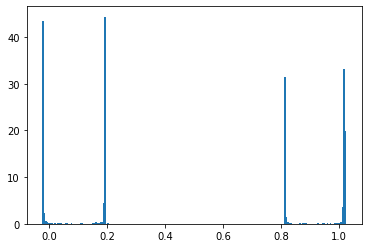

sampling loop time step: 100%|██████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 1431.19it/s]


torch.Size([2000, 1, 1, 1])


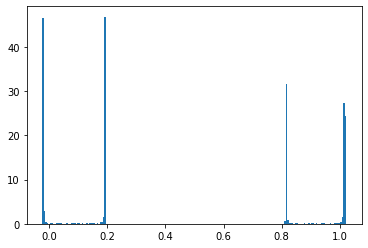

sampling loop time step: 100%|████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 1350.24it/s]


torch.Size([2000, 1, 1, 1])


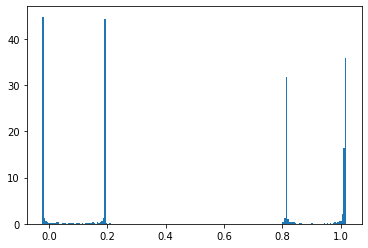

sampling loop time step: 100%|████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 1252.52it/s]


torch.Size([2000, 1, 1, 1])


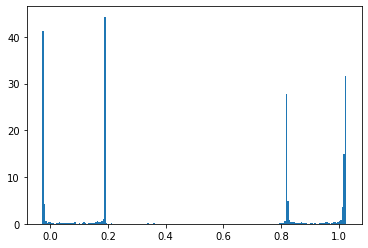

sampling loop time step: 100%|████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1200.67it/s]


torch.Size([2000, 1, 1, 1])


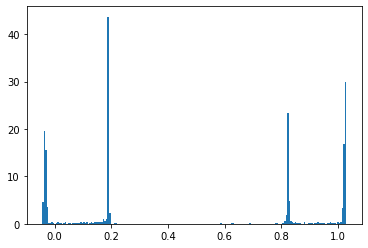

sampling loop time step: 100%|██████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1193.26it/s]


torch.Size([2000, 1, 1, 1])


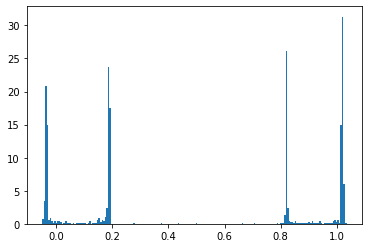

sampling loop time step: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 738.53it/s]


torch.Size([2000, 1, 1, 1])


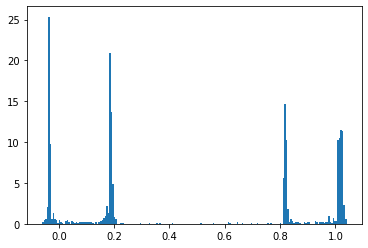

sampling loop time step: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 958.59it/s]


torch.Size([2000, 1, 1, 1])


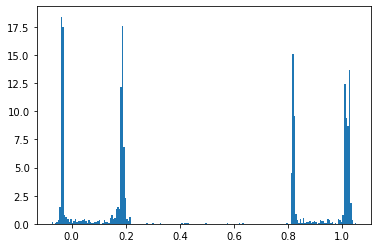

sampling loop time step: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 670.12it/s]


torch.Size([2000, 1, 1, 1])


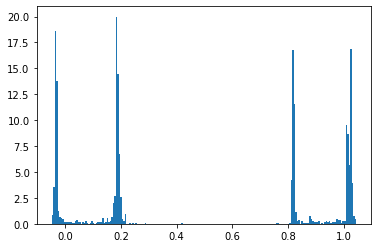

In [16]:

for model in models:
    sampled_images = model.sample(batch_size=2000)
    print(sampled_images.shape)  # (4, 3, 128, 128)
    sampled_images = sampled_images[:, 0, 0, 0]
    # print(sampled_images)
    _ = plt.hist(sampled_images.cpu().numpy(), density=True, bins=200)
    plt.show()

In [17]:
def show_trajectories(model, refmodel, numtraj=10, range=(-1.2, 1.2)):
    x_T = np.linspace(range[0], range[1], numtraj)
    
    sampled_images, times, imgacc, x0acc = refmodel.sample(numtraj, 
                                                        x_T=torch.tensor(x_T)[:, None, None, None].to(torch.float)
                                                                     .to(diffusion.betas.device),
                                                           return_trajectories=True)
    
    
    print(len(times), len(imgacc))
    
    trajs = [[x_t_i] for x_t_i in x_T]
    
    for img in imgacc:
        img = img[:,0,0,0].cpu().numpy()
        for img_i, traj in zip(img, trajs):
            traj.append(img_i)
        
    fig = plt.figure(figsize = (15,10))
    ax = fig.add_subplot(111)
    for traj in trajs:
        ax.plot(times, traj, "blue")
    ax.set_title('trajectories')
    
    sampled_images, times, imgacc, x0acc = model.sample(numtraj, 
                                                        x_T=torch.tensor(x_T)[:, None, None, None].to(torch.float)
                                                                     .to(diffusion.betas.device),
                                                       return_trajectories=True)
    
    print(len(times), len(imgacc))
    
    trajs = [[x_t_i] for x_t_i in x_T]
    
    for img in imgacc:
        img = img[:,0,0,0].cpu().numpy()
        for img_i, traj in zip(img, trajs):
            traj.append(img_i)
        
    for traj in trajs:
        ax.plot(times, traj, "ro-")
    ax.set_title('trajectories')

    plt.show()

    return trajs

sampling loop time step: 100%|██████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 1265.78it/s]


513 512


sampling loop time step: 100%|██████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1036.59it/s]


9 8


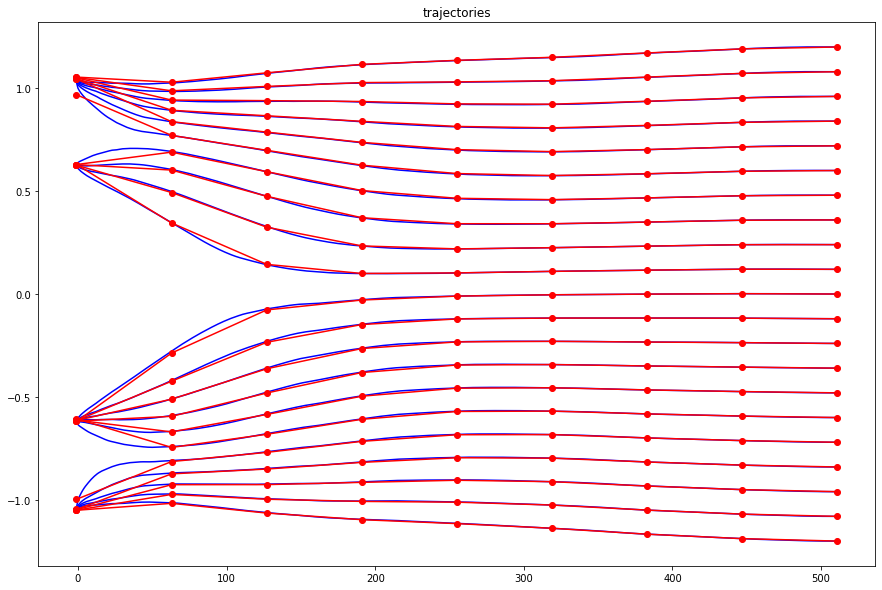

In [24]:
_ = show_trajectories(models1[-3], basemodel, numtraj=21)

sampling loop time step: 100%|██████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 1445.43it/s]


513 512


sampling loop time step: 100%|██████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1458.25it/s]


9 8


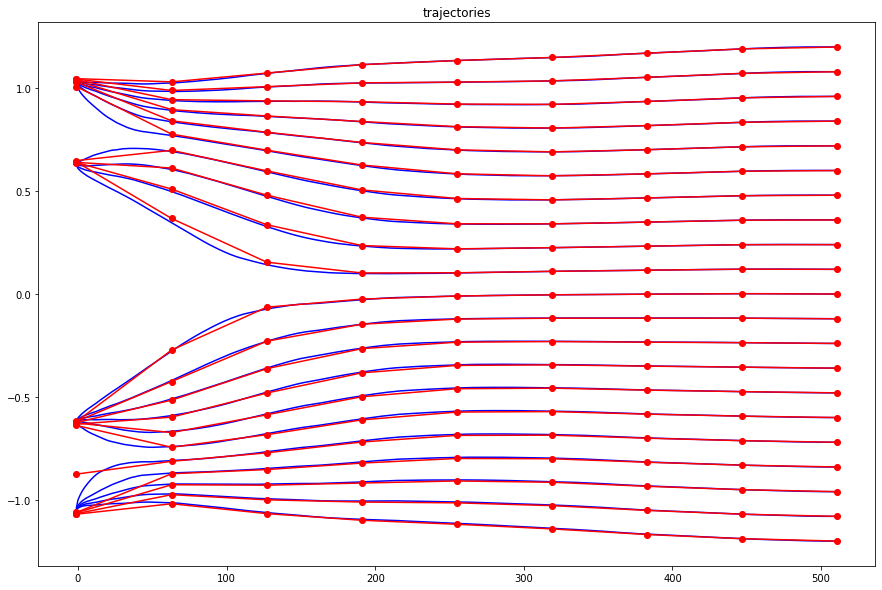

In [27]:
_ = show_trajectories(models[-4], basemodel, numtraj=21)

In [20]:
def compute_traj_dist(model, model2, refmodel, batsize=2000):
    x_T = torch.randn((batsize, 1, 1, 1)).to(device)
    samples = model.sample(batsize, x_T=x_T)
    samples2 = model2.sample(batsize, x_T=x_T)
    refsamples = refmodel.sample(batsize, x_T=x_T)
    ret = torch.norm(samples - refsamples)**2
    ret2 = torch.norm(samples2 - refsamples)**2
    return ret, ret2
    # print(((samples - refsamples) ** 2).sum())
    # print(samples[:5], refsamples[:5])

In [36]:
retas, retbs = [], []
for _ in range(20):
    reta, retb = compute_traj_dist(models1[-1], models[-1], basemodel)
    retas.append(reta)
    retbs.append(retb)
    
retas = torch.stack(retas)
retbs = torch.stack(retbs)
    
print(f"{torch.mean(retas).item():.4f}+-{torch.std(retas):.4f}, {torch.mean(retbs).item():.4f}+-{torch.std(retbs):.4f}")

sampling loop time step: 100%|██████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 1405.70it/s]

1.3332+-0.1854, 1.4090+-0.2370
